## **Modélisation Random Forest sur la base de données du DRiM Game**

---





In [ ]:
from google.colab import files
files.upload() #charger les 3 bases de données, ou seulement tot_statio

In [8]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings

# Supprimer les wanings
warnings.filterwarnings("ignore")



*  **Importation des bases de données et vérification**



In [3]:
db_chr2 = pd.read_excel('chr2_less_diff.xlsx')
db_chr8 = pd.read_excel('chr8_less_diff.xlsx')
db_tot = pd.read_excel('tot_less_diff.xlsx')

db_tot = pd.DataFrame(data=db_tot)
db_chr8 = pd.DataFrame(data=db_chr8)
db_chr2 = pd.DataFrame(data=db_chr2)

#On se concentrera pour l'instant sur la base de données "db_tot"
#où les individus mal classés et bien classés ne sont pas séparés

In [4]:
print("db_tot :", db_tot.shape)
print("db_chr8 :",db_chr8.shape)
print("db_chr2 :",db_chr2.shape)

db_tot : (33, 72)
db_chr8 : (33, 84)
db_chr2 : (33, 80)


## Modélisation RF sur Base_tot

*  **Préparation de nos jeux tests set d'entraînement pour BASE_TOT**



In [55]:
# On créé notre X (tous nos predicteurs)
X = db_tot.iloc[:,1:] 
# On créé notre y (unicolonne)
y = db_tot.iloc[:,0] 

# Jeu d'entrainement
X_train = X.iloc[:24,:] 
y_train = y.iloc[:24]

# Jeu test
# On garde les 8 dernières observations pour les prévisions
X_test = X.iloc[25:,:] 
y_test = y.iloc[25:]

In [56]:
# Créer un modèle de forêt aléatoire en spécifiant les hyperparamètres souhaités
rf = RandomForestRegressor(random_state=1212)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=1212)

In [57]:
y_pred = rf.predict(X_test)
print("Nos prédictions sont :", y_pred)

Nos prédictions sont : [0.01506558 0.02858461 0.02740745 0.03830434 0.03882826 0.03899038
 0.03489903 0.04266627]


In [58]:
#Erreur quadratique moyenne
MSE_0 = mean_squared_error(y_test, y_pred)

In [59]:
#Racine carrée de notre MSE
RMSE_0 = np.sqrt(mean_squared_error(y_test,y_pred)) 


* **Etude de l'importance des variables**

In [60]:
#!pip install shap

In [61]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

p25_DUR_IMP_ENC          0.119734
p5_DER_NOT_OCT_RCAL      0.097778
mean_DUR_MAX_ENC         0.052998
CD_QUAL_VEH_1            0.051026
p95_RAT_APPO             0.049744
                           ...   
p75_RAT_RAN_IMP_Z_DUR    0.000246
p95_DUR_DER_IMP_REGUL    0.000170
PIB                      0.000121
clim_emp                 0.000108
p5_RAT_APPO              0.000000
Length: 71, dtype: float64

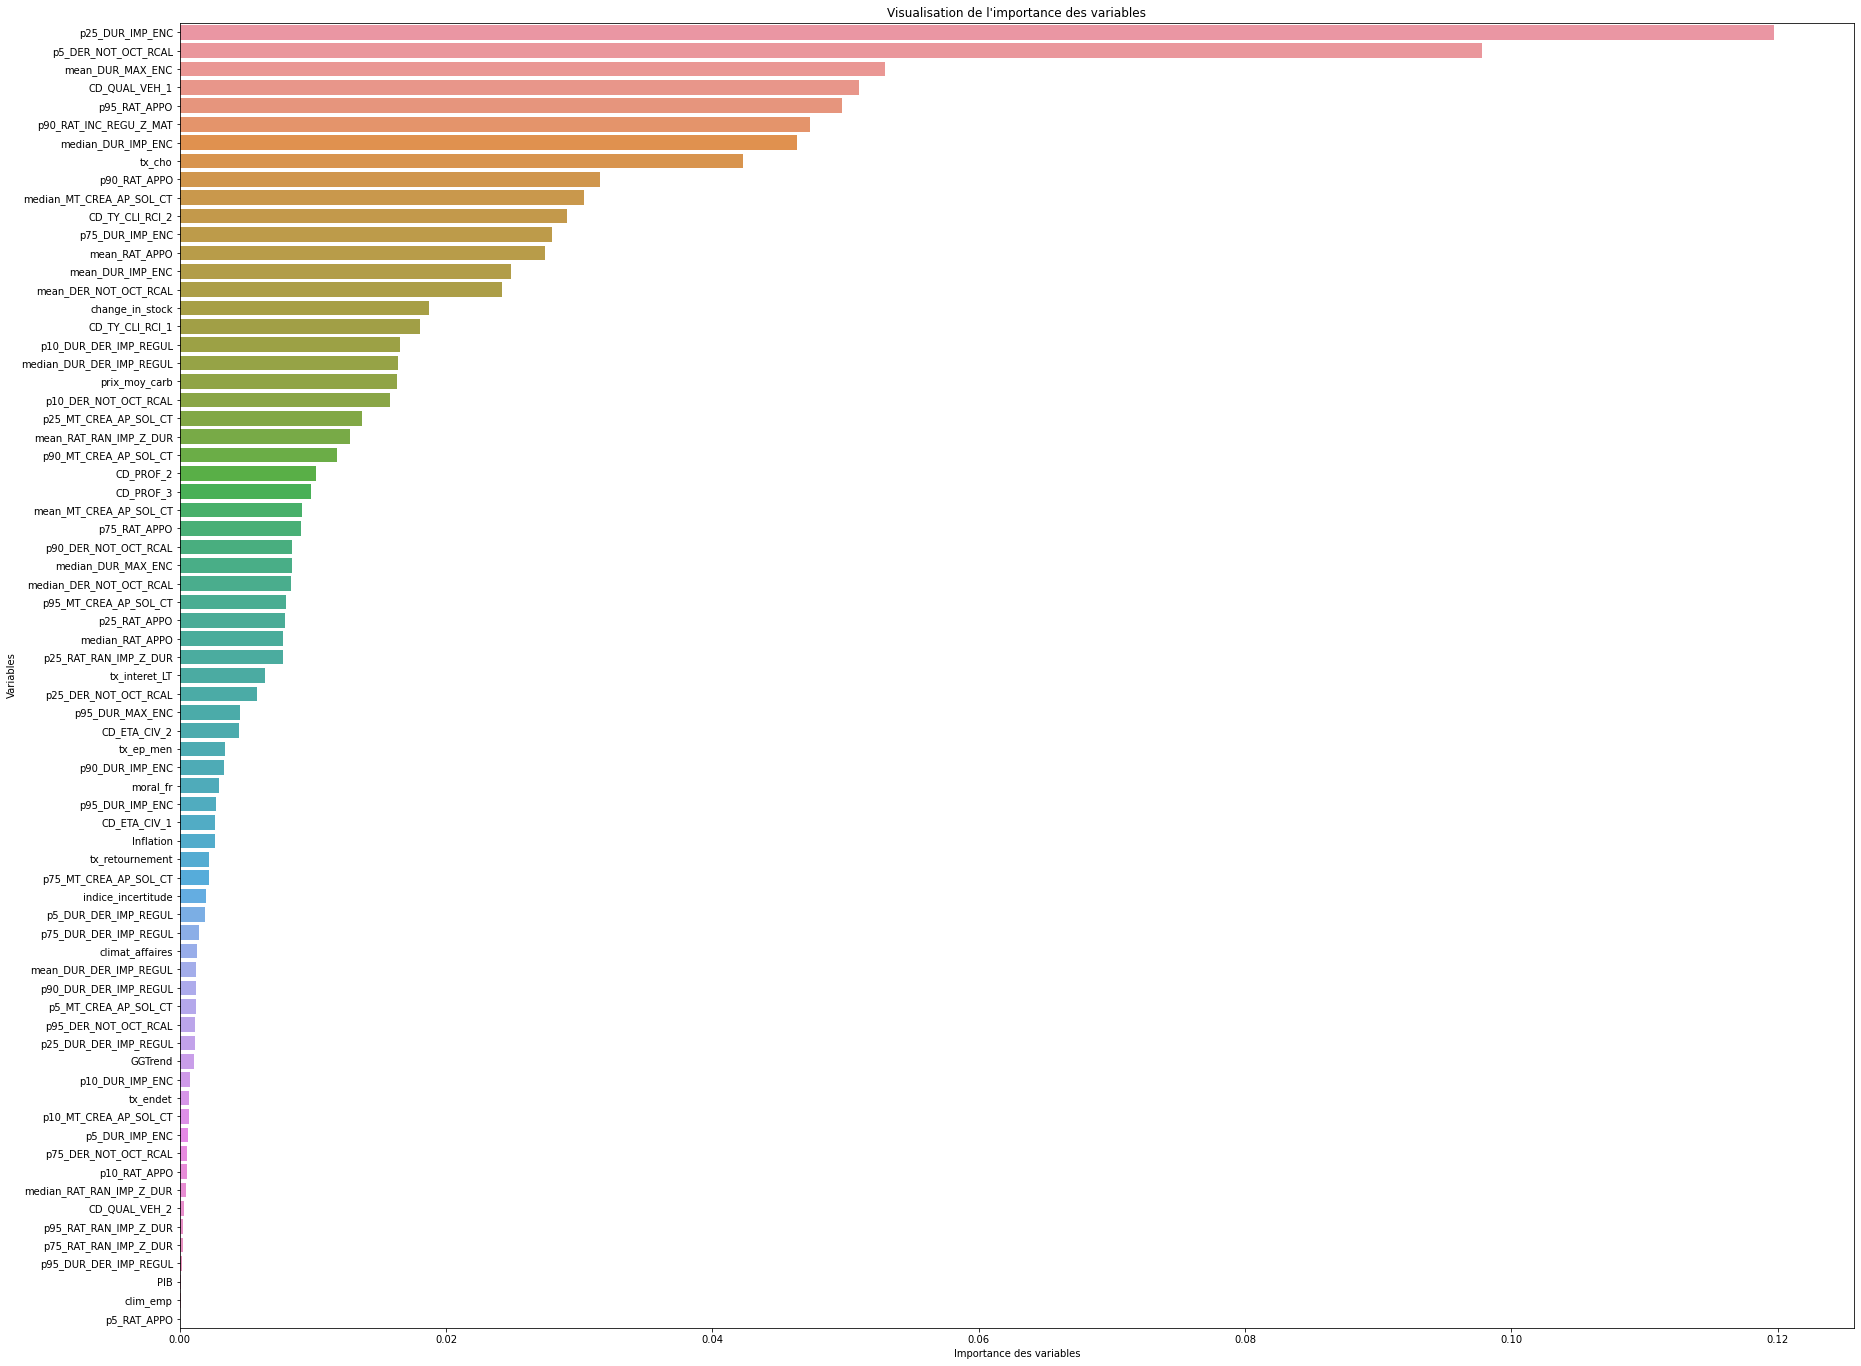

In [62]:
ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=db_chr2)
ax.set_title("Visualisation de l'importance des variables")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Importance des variables")
ax.set_ylabel("Variables")
plt.show()

In [63]:
# On récupère nos 5 features avec l'importance la plus élevée
indices = np.argsort(rf.feature_importances_)[-5:]
print([X_train.columns[i] for i in indices])

['p95_RAT_APPO', 'CD_QUAL_VEH_1', 'mean_DUR_MAX_ENC', 'p5_DER_NOT_OCT_RCAL', 'p25_DUR_IMP_ENC']


In [64]:
# Créez une liste vide pour stocker les fonctionnalités à supprimer.
list_feat_to_delete = []

# Boucle sur les caractéristiques de l'ensemble de données
for i, feat_name in enumerate(X_train.columns) :
  # Vérifier si l'importance de la caractéristique est inférieure à 0.001
  if rf.feature_importances_[i] < 0.001 :
    # Si l'importance de la caractéristique est inférieure à 0,001, ajoutez la caractéristique à la liste.
    list_feat_to_delete.append(feat_name)

print("La liste contient", len(list_feat_to_delete), "variables que nous supprimons (importance trop faible)")

La liste contient 14 variables que nous supprimons (importance trop faible)


In [65]:
# Suppression de ces variables
X_train2 = X_train.drop(list_feat_to_delete, axis=1)
X_test2 = X_test.drop(list_feat_to_delete, axis=1)

In [66]:
rf.fit(X_train2, y_train)

y_pred2 = rf.predict(X_test2)

In [67]:
MSE_imp = mean_squared_error(y_test, y_pred2)

#racine carrée de notre MSE
RMSE_imp = np.sqrt(mean_squared_error(y_test,y_pred2)) 

if MSE_imp <= MSE_0:
  print("L'importance des variables nous a permis d'améliorer notre modèle : MSE_imp",round(MSE_imp,4),"<", "MSE_0", round(MSE_0,4))
else:
  print("Raté",round(MSE_imp,2),">",round(MSE_0,2))


L'importance des variables nous a permis d'améliorer notre modèle : MSE_imp 0.0042 < MSE_0 0.0046



* **Amélioration de notre modèle grâce à la recherche des meilleurs hyperparamètres**





In [68]:
# On crée notre grid search d'hyperparameter
param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
}

# On initialise notre RF
rf2 = RandomForestRegressor()

grid_search = GridSearchCV(rf2, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train2, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1')

In [69]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
print("La meilleur combinaison d'estimateur est: " + str(grid_search.best_params_))

La meilleur combinaison d'estimateur est: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [70]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
rf2 = RandomForestRegressor(max_depth=2, min_samples_split=2, n_estimators=10)
rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=10)

In [71]:
y_pred_fit = rf2.predict(X_test)
y_pred_fit

array([0.02018966, 0.02596693, 0.02331716, 0.02331716, 0.01692238,
       0.04518542, 0.05054264, 0.07369172])

On compare notre modèle amélioré avec notre meilleur modèle précédent 

In [72]:
MSE_fit = mean_squared_error(y_test, y_pred_fit)
RMSE_fit = np.sqrt(mean_squared_error(y_test,y_pred_fit)) 

if MSE_0>MSE_imp:
  if MSE_fit<=MSE_imp:
    print("La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit",round(MSE_fit,4),"<", "MSE_imp", round(MSE_imp,4))
  else:
    print("Raté",round(MSE_fit,4),">",round(MSE_imp,4))   
else:
  if MSE_0<=MSE_imp:
    print("La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit",round(MSE_fit,4),"<", "MSE_0", round(MSE_0,4))
  else:
    print("Raté",round(MSE_fit,4),">",round(MSE_0,4)) 

La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit 0.0034 < MSE_imp 0.0042


In [73]:
if MSE_fit > MSE_0 and MSE_imp > MSE_0:
  print("Nous gardons donc le modèle de base (0)")
elif MSE_fit > MSE_0 and MSE_imp < MSE_0:
  print("Nous gardons donc le modèle basé sur l'importance des variables")
else:
  print("Nous gardons le modèle qui combine le modèle tuné et l'importance des variables")

Nous gardons le modèle qui combine le modèle tuné et l'importance des variables


## Modélisation RF sur Base_chr2

*  **Préparation de nos jeux tests set d'entraînement pour BASE_CHR2**

In [104]:
# On créé notre X (tous nos predicteurs)
X = db_chr2.iloc[:,1:] 
# On créé notre y (unicolonne)
y = db_chr2.iloc[:,0] 

# Jeu d'entrainement
X_train = X.iloc[:24,:] 
y_train = y.iloc[:24]

# Jeu test
# On garde les 8 dernières observations pour les prévisions
X_test = X.iloc[25:,:] 
y_test = y.iloc[25:]

In [105]:
# Créer un modèle de forêt aléatoire
rf = RandomForestRegressor(random_state=1212)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Nos prédictions sont donc :", y_pred)

Nos prédictions sont donc : [0.2294 0.2279 0.2328 0.2316 0.2307 0.2293 0.2162 0.2156]


In [106]:
MSE_0 = mean_squared_error(y_test, y_pred)
RMSE_0 = np.sqrt(mean_squared_error(y_test,y_pred)) 

* **Importance des variables**

In [107]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

CD_QUAL_VEH_1               0.235409
p10_RAT_APPO                0.162239
p25_DUR_NOT_OCT_RCAL        0.103764
median_MT_CREA_AP_SOL_CT    0.095487
CD_QUAL_VEH_2               0.078217
                              ...   
p75_DUR_IMP_ENC             0.000151
p75_RAT_RAN_IMP_Z_DUR       0.000068
p95_DUR_IMP_ENC             0.000065
p90_DUR_IMP_ENC             0.000000
mean_RAT_INC_REGU_Z_MAT     0.000000
Length: 79, dtype: float64

In [108]:
# On récupère nos 5 features avec l'importance la plus élevée
indices = np.argsort(rf.feature_importances_)[-5:]
print([X_train.columns[i] for i in indices])

['CD_QUAL_VEH_2', 'median_MT_CREA_AP_SOL_CT', 'p25_DUR_NOT_OCT_RCAL', 'p10_RAT_APPO', 'CD_QUAL_VEH_1']


In [109]:
# Créez une liste vide pour stocker les fonctionnalités à supprimer.
list_feat_to_delete = []

# Boucle sur les caractéristiques de l'ensemble de données
for i, feat_name in enumerate(X_train.columns) :
  # Vérifier si l'importance de la caractéristique est inférieure à 0.001
  if rf.feature_importances_[i] < 0.001 :
    # Si l'importance de la caractéristique est inférieure à 0,001, ajoutez la caractéristique à la liste.
    list_feat_to_delete.append(feat_name)

print("La liste contient", len(list_feat_to_delete), "variables que nous supprimons (importance trop faible)")

X_train2 = X_train.drop(list_feat_to_delete, axis=1)

X_test2 = X_test.drop(list_feat_to_delete, axis=1)

La liste contient 19 variables que nous supprimons (importance trop faible)


In [110]:
rf.fit(X_train2, y_train)

y_pred2 = rf.predict(X_test2)

In [111]:
#MSE
MSE_imp = mean_squared_error(y_test, y_pred2)

#RMSE
RMSE_imp = np.sqrt(mean_squared_error(y_test,y_pred2)) 


if MSE_imp <= MSE_0:
  print("L'importance des variables nous a permis d'améliorer notre modèle : MSE_imp",round(MSE_imp,5),"<", "MSE_0", round(MSE_0,5))
else:
  print("Raté",round(MSE_imp,2),">",round(MSE_0,2))


Raté 0.0 > 0.0


* **Amélioration du modèle via GridSearch**

In [112]:
# On créer notre grid search d'hyperparameter
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
};

# On initialise notre RF
rf2 = RandomForestRegressor();

grid_search = GridSearchCV(rf2, param_grid, cv=5, scoring='f1');
grid_search.fit(X_train2, y_train);

In [113]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
print("La meilleur combinaison d'estimateur est: " + str(grid_search.best_params_))

La meilleur combinaison d'estimateur est: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [114]:
#On enregistre les meilleurs paramètres dans une variable
best_params = grid_search.best_params_

In [115]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
rf2 = RandomForestRegressor(max_depth=2, min_samples_split=2, n_estimators=10)
rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=10)

In [116]:
y_pred_fit = rf2.predict(X_test)
y_pred_fit

array([0.22339683, 0.22764683, 0.22481944, 0.21948611, 0.22023611,
       0.23479167, 0.210971  , 0.21591544])

In [119]:
MSE_fit = mean_squared_error(y_test, y_pred_fit)
RMSE_fit = np.sqrt(mean_squared_error(y_test,y_pred_fit)) 

if MSE_0>MSE_imp:
  if MSE_fit<=MSE_imp:
    print("La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit",round(MSE_fit,4),"<", "MSE_imp", round(MSE_imp,4))
  else:
    print("Raté",round(MSE_fit,4),">",round(MSE_imp,4))   
else:
  if MSE_0<=MSE_imp:
    print("La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit",round(MSE_fit,4),"<", "MSE_0", round(MSE_0,4))
  else:
    print("Raté",round(MSE_fit,4),">",round(MSE_0,4)) 

In [120]:
if MSE_fit > MSE_0 and MSE_imp > MSE_0:
  print("Nous gardons donc le modèle de base (0)")
elif MSE_fit > MSE_0 and MSE_imp < MSE_0:
  print("Nous gardons donc le modèle basé sur l'importance des variables")
else:
  print("Nous gardons le modèle qui combine le modèle tuné et l'importance des variables")

Nous gardons le modèle qui combine le modèle tuné et l'importance des variables


## Modélisation RF sur Base_chr8

*  **Préparation de nos jeux tests set d'entraînement pour BASE_CHR2**

In [9]:
# On créé notre X (tous nos predicteurs)
X = db_chr8.iloc[:,1:] 
# On créé notre y (unicolonne)
y = db_chr8.iloc[:,0] 

# Jeu d'entrainement
X_train = X.iloc[:24,:] 
y_train = y.iloc[:24]

# Jeu test
# On garde les 8 dernières observations pour les prévisions
X_test = X.iloc[25:,:] 
y_test = y.iloc[25:]

In [10]:
# Créer un modèle de forêt aléatoire
rf = RandomForestRegressor(random_state=1212)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Nos prédictions sont donc :", y_pred)

Nos prédictions sont donc : [14.1045 14.2681 14.0707 14.1762 14.7387 15.0563 15.0298 15.012 ]


In [11]:
MSE_0 = mean_squared_error(y_test, y_pred)
RMSE_0 = np.sqrt(mean_squared_error(y_test,y_pred)) 

* **Importance des variables**

In [12]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

p95_RAT_INC_REGU_Z_MAT     0.285340
p90_RAT_INC_REGU_Z_MAT     0.241991
mean_RAT_INC_REGU_Z_MAT    0.098117
p25_MT_CREA_AP_SOL_CT      0.059761
p75_RAT_INC_REGU_Z_MAT     0.049882
                             ...   
p10_DUR_IMP_ENC            0.000284
p25_DUR_MAX_IMP            0.000119
PIB                        0.000112
p95_DUR_MAX_IMP            0.000054
median_DUR_MAX_IMP         0.000022
Length: 83, dtype: float64

In [13]:
# On récupère nos 5 features avec l'importance la plus élevée
indices = np.argsort(rf.feature_importances_)[-5:]
print([X_train.columns[i] for i in indices])

['p75_RAT_INC_REGU_Z_MAT', 'p25_MT_CREA_AP_SOL_CT', 'mean_RAT_INC_REGU_Z_MAT', 'p90_RAT_INC_REGU_Z_MAT', 'p95_RAT_INC_REGU_Z_MAT']


In [14]:
# Créer une liste vide pour stocker les fonctionnalités à supprimer.
list_feat_to_delete = []

# Boucle sur les caractéristiques de l'ensemble de données
for i, feat_name in enumerate(X_train.columns) :
  # Vérifier si l'importance de la caractéristique est inférieure à 0.001
  if rf.feature_importances_[i] < 0.001 :
    # Si l'importance de la caractéristique est inférieure à 0,001, ajoutez la caractéristique à la liste.
    list_feat_to_delete.append(feat_name)

print("La liste contient", len(list_feat_to_delete), "variables que nous supprimons (importance trop faible)")

X_train2 = X_train.drop(list_feat_to_delete, axis=1)

X_test2 = X_test.drop(list_feat_to_delete, axis=1)

La liste contient 24 variables que nous supprimons (importance trop faible)


In [15]:
rf.fit(X_train2, y_train)

y_pred2 = rf.predict(X_test2)

In [16]:
#MSE
MSE_imp = mean_squared_error(y_test, y_pred2)

#RMSE
RMSE_imp = np.sqrt(mean_squared_error(y_test,y_pred2)) 

if MSE_imp <= MSE_0:
  print("L'importance des variables nous a permis d'améliorer notre modèle : MSE_imp",round(MSE_imp,4),"<", "MSE_0", round(MSE_0,4))
else:
  print("Raté",round(MSE_imp,2),">",round(MSE_0,2))

L'importance des variables nous a permis d'améliorer notre modèle : MSE_imp 1.6671 < MSE_0 1.7983


* **Amélioration du modèle via GridSearch**

In [17]:
# On créer notre grid search d'hyperparameter
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
}

# On initialise notre RF
rf2 = RandomForestRegressor()

grid_search = GridSearchCV(rf2, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train2, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='f1')

In [18]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
print("La meilleur combinaison d'estimateur est: " + str(grid_search.best_params_))

La meilleur combinaison d'estimateur est: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [19]:
#On enregistre les meilleurs paramètres dans une variable
best_params = grid_search.best_params_

In [20]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
rf2 = RandomForestRegressor(max_depth=2, min_samples_split=2, n_estimators=10)
rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=10)

In [21]:
y_pred_fit = rf2.predict(X_test)
y_pred_fit

array([14.04231742, 14.1858829 , 14.02336504, 14.13120595, 14.60895433,
       14.80029123, 14.86016266, 14.81921623])

In [22]:
MSE_fit = mean_squared_error(y_test, y_pred_fit)
RMSE_fit = np.sqrt(mean_squared_error(y_test,y_pred_fit)) 

if MSE_0>MSE_imp:
  if MSE_fit<=MSE_imp:
    print("La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit",round(MSE_fit,4),"<", "MSE_imp", round(MSE_imp,4))
  else:
    print("Raté",round(MSE_fit,4),">",round(MSE_imp,4))   
else:
  if MSE_0<=MSE_imp:
    print("La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit",round(MSE_fit,4),"<", "MSE_0", round(MSE_0,4))
  else:
    print("Raté",round(MSE_fit,4),">",round(MSE_0,4)) 

La recherche des hyperparamètres optimaux nous a permis d'améliorer notre modèle : MSE_fit 1.4899 < MSE_imp 1.6671


In [23]:
if MSE_fit > MSE_0 and MSE_imp > MSE_0:
  print("Nous gardons donc le modèle de base (0)")
elif MSE_fit > MSE_0 and MSE_imp < MSE_0:
  print("Nous gardons donc le modèle basé sur l'importance des variables")
else:
  print("Nous gardons le modèle qui combine le modèle tuné et l'importance des variables")

Nous gardons le modèle qui combine le modèle tuné et l'importance des variables
